# Using Current Data To Make Recommendations
### Model #1: (Classification - Fully Paid vs. Default) 
### Model #2: ( Regression - Annualized Return %)

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from functions_and_objects import (impute_means_zeros_maxs_X,parse_percentage,
                                   clean_new_LC_data_classification_current,clean_LC_data_classification_eval,
                                   preprocessing_current, preprocessing_future_test, columns_list, 
                                   nan_max_cols, nan_mean_cols, nan_zero_cols, dtype,
                                   one_hot_encode_current, concat_X_and_6ohe_dfs,
                                   prep_all_df_for_classification, 
                                   view_columns_by_number_of_rows_that_have_nan,
                                   current_pipeline)
from functions_and_objects import (prep_df_for_regression_current,
                                   calc_annu_return,impute_annu_return_to_y,
                                   scale_current)

import joblib
from sklearn.metrics import (accuracy_score, precision_score, recall_score, #classification
                             f1_score, roc_auc_score, roc_curve,precision_recall_fscore_support, #classification
                             r2_score,mean_squared_error) #regression
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

### Import New Data from 2018-2019

- These files contain complete loan data for all loans issued through the time period stated, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. The file containing loan data through the "present" contains complete loan data for all loans issued through the previous completed calendar quarter.

In [2]:
raw_q12019 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2019Q1.csv',header=1)
raw_q42018 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2018Q4.csv',header=1)
raw_q32018 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2018Q3.csv',header=1)
raw_q22018 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2018Q2.csv',header=1)
raw_q12018 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2018Q1.csv',header=1)
dfs_list = [raw_q42018,
            raw_q32018,
            raw_q22018,
            raw_q12018]

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,144,145,146) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,129,130,131,134,135,136,139,144,145,146) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(raw_q42018.shape)
print(raw_q32018.shape)
print(raw_q22018.shape)
print(raw_q12018.shape)


(128414, 150)
(128196, 150)
(130774, 150)
(107866, 150)


### Load DF from Pipeline

In [4]:
(X_current_regr, y_current, table_all_current) = current_pipeline(dfs_list, 'nn_v7.joblib', 'rf_regr_v3.joblib')

/home/jupyter/peervest/functions_and_objects.py:275: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  raw_lc_df['earliest_cr_line'] = pd.to_timedelta(pd.to_datetime(raw_lc_df['earliest_cr_line'])).dt.days
Using TensorFlow backend.
W0708 23:39:38.071706 140507433768704 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0708 23:39:38.091862 140507433768704 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0708 23:39:38.194797 140507433768704 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_

In [22]:
len(y_current[(y_current['prob_default'] < 0.01) & (y_current['annu_return'] > 0.12)])

374

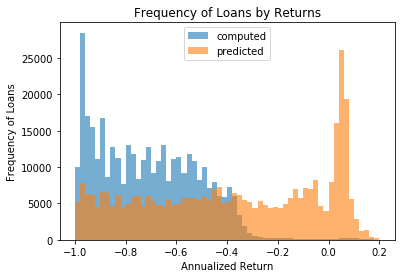

In [6]:
plt.hist(y_current['annu_return'],bins=60,range=(-1,0.2),label='computed',alpha=0.6)
plt.hist(y_current['return_preds'],bins=60,range=(-1,0.2),label='predicted',alpha=0.6)
plt.xlabel('Annualized Return')
plt.ylabel('Frequency of Loans')
plt.legend()
plt.title('Frequency of Loans by Returns')
plt.show()

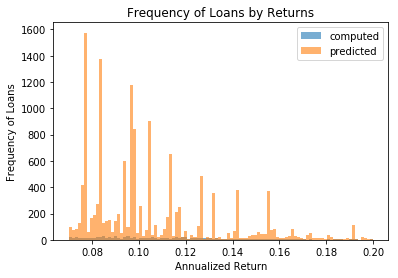

In [13]:
plt.hist(y_current['annu_return'],bins=100,range=(0.07,0.2),label='computed',alpha=0.6)
plt.hist(y_current['return_preds'],bins=100,range=(0.07,0.2),label='predicted',alpha=0.6)
plt.xlabel('Annualized Return')
plt.ylabel('Frequency of Loans')
plt.legend()
plt.title('Frequency of Loans by Returns')
plt.show()

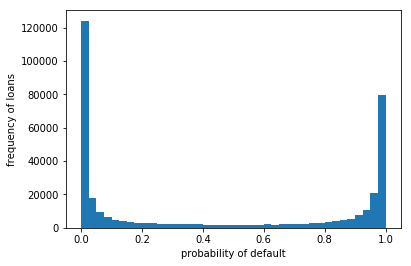

In [19]:
plt.hist(y_current['prob_default'],bins=40, range=(0,1))
plt.xlabel('probability of default')
plt.ylabel('frequency of loans')
plt.show()

### Try it Manually - Classification

In [3]:
clean_lc_df_current = clean_new_LC_data_classification_current(dfs_list)
X_current, y_current = preprocessing_current(clean_lc_df_current)
(ohe_home_ownership, ohe_purpose, ohe_zip_code, 
 ohe_application_type, ohe_sub_grade, ohe_emp_title_2) = one_hot_encode_current(X_current)
X_current_classif = concat_X_and_6ohe_dfs(X_current, ohe_home_ownership, ohe_purpose, ohe_zip_code,
                                      ohe_application_type, ohe_sub_grade, ohe_emp_title_2)
X_current_regr = concat_X_and_6ohe_dfs(X_current, ohe_home_ownership, ohe_purpose, ohe_zip_code, 
                                   ohe_application_type, ohe_sub_grade, ohe_emp_title_2)
prep_all_df_for_classification(X_current_classif) #drops columns in place
class_model = joblib.load('nn_v7.joblib')

/home/jupyter/peervest/functions_and_objects.py:275: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  raw_lc_df['earliest_cr_line'] = pd.to_timedelta(pd.to_datetime(raw_lc_df['earliest_cr_line'])).dt.days
Using TensorFlow backend.
W0708 04:07:58.662530 140604772128512 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0708 04:07:58.684106 140604772128512 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0708 04:07:58.793218 140604772128512 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_

### Scaling X_current_classif

In [19]:
ss = StandardScaler()
X_current_classif_s = ss.fit_transform(X_current_classif)

In [20]:
current_class_s_preds_proba = class_model.predict_proba(X_current_classif_s,verbose=1)

361423/361423 [==============================] - 36s 101us/step


In [21]:
current_class_s_preds_proba

array([[0.87482095],
       [0.3192853 ],
       [0.99108195],
       ...,
       [0.9613179 ],
       [0.99492466],
       [0.9953492 ]], dtype=float32)

In [22]:
class_model.predict(X_current_classif_s)

array([[0.87482095],
       [0.3192853 ],
       [0.99108195],
       ...,
       [0.9613179 ],
       [0.99492466],
       [0.9953492 ]], dtype=float32)

In [23]:
class_model.predict_classes(X_current_classif)

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [0]], dtype=int32)

(array([ 79378.,  20983.,  10846.,   7381.,   5533.,   4509.,   3877.,
          3352.,   3062.,   2757.,   2485.,   2379.,   2251.,   2106.,
          1973.,   2000.,   1917.,   1943.,   1816.,   1861.,   1843.,
          1870.,   1754.,   1937.,   2007.,   1987.,   2074.,   2104.,
          2275.,   2453.,   2624.,   2880.,   3082.,   3567.,   4111.,
          4877.,   6488.,   9344.,  17663., 124074.]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ], dtype=float32),
 <a list of 40 Patch objects>)

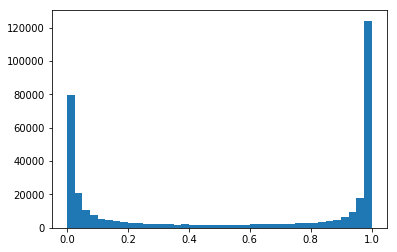

In [26]:
plt.hist(current_class_s_preds_proba,bins=40,range=(0,1))

(array([4565., 3747., 3339., 2971., 2649., 2477., 2251., 2096., 1965.,
        1894., 1799., 1717., 1667., 1535., 1612., 1534., 1533., 1550.,
        1432., 1488., 1479., 1497., 1480., 1399., 1549., 1606., 1631.,
        1567., 1696., 1672., 1807., 1927., 2018., 2156., 2324., 2457.,
        2735., 3037., 3425., 3983.]),
 array([0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22, 0.24, 0.26, 0.28, 0.3 ,
        0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44, 0.46, 0.48, 0.5 , 0.52,
        0.54, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66, 0.68, 0.7 , 0.72, 0.74,
        0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88, 0.9 ], dtype=float32),
 <a list of 40 Patch objects>)

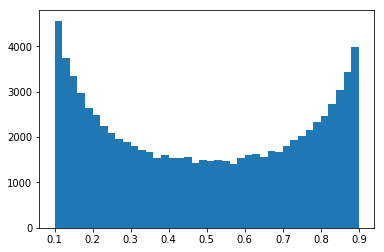

In [27]:
plt.hist(current_class_s_preds_proba,bins=40,range=(0.1,0.9))

In [33]:
#Probability of Default
1-current_class_s_preds_proba[:,0]

array([0.12517905, 0.6807147 , 0.00891805, ..., 0.0386821 , 0.00507534,
       0.00465077], dtype=float32)

# Recommendation Table

In [37]:
table_all_current.loc[table_all_current['funded_amnt'] < table_all_current['loan_amnt']]

,prob_default,prob_fullypaid,annu_return,return_preds,loan_amnt,funded_amnt,total_pymnt,int_rate,emp_length,annual_inc,...,emp_title_2_Technician,emp_title_2_Truck Driver,emp_title_2_Vice President,emp_title_2_driver,emp_title_2_manager,emp_title_2_owner,emp_title_2_sales,emp_title_2_supervisor,emp_title_2_teacher,emp_title_2_truck driver
id,,,,,,,,,,,,,,,,,,,,,


In [35]:
print(table_all_current.columns)

Index(['prob_default', 'prob_fullypaid', 'annu_return', 'return_preds',
       'loan_amnt', 'funded_amnt', 'total_pymnt', 'int_rate', 'emp_length',
       'annual_inc',
       ...
       'emp_title_2_Technician', 'emp_title_2_Truck Driver',
       'emp_title_2_Vice President', 'emp_title_2_driver',
       'emp_title_2_manager', 'emp_title_2_owner', 'emp_title_2_sales',
       'emp_title_2_supervisor', 'emp_title_2_teacher',
       'emp_title_2_truck driver'],
      dtype='object', length=1112)


In [ ]:
table_all_current

In [28]:
funds = input("Enter Dollars Available to Invest (integer):")
risk = input("Enter Risk Tolerance (Maximum Probability of Default):")
reward = input("Enter Desired Return (Minimum Predicted Annualized Return:")

columns = ['prob_default', 'return_preds', 'loan_amnt','funded_amnt']

table_all_current.loc[(table_all_current['prob_default'] <= risk) & (table_all_current['return_preds'] >= reward),]

Enter Risk Tolerance (Maximum Probability of Default):0.1
Enter Desired Return (Minimum Predicted Annualized Return:.1


# Recommendation Portfolio Summary Values

In [ ]:
# 1. Expected Return (Portfolio)
# 2. Dollar Weighted Average Probability of Default
# 3. Shropshire Ratio (similar to Sharpe Ratio)

# Recommendation Portfolio Descriptive Visuals